In [5]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns

In [6]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 15 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(20, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

Text(0, 0.5, 'cell #')

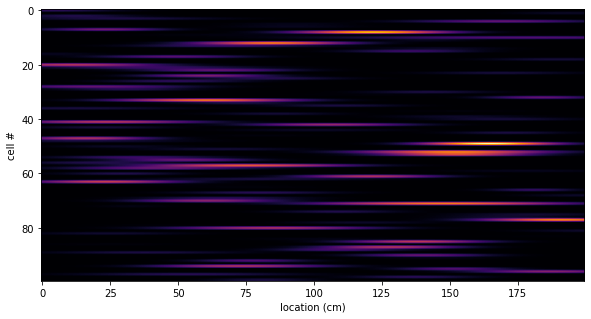

In [7]:
plt.imshow(true_firing_rate_maps, cmap='inferno')
plt.xlabel('location (cm)')
plt.ylabel('cell #')

In [8]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

In [9]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [10]:
spike_positions = [np.interp(s, t, x) for s in spikes]

space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

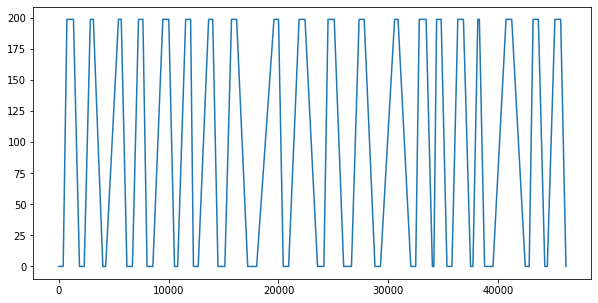

In [11]:
plt.plot(x)

In [12]:
import ot

def bin_spikes(spikes, times):
    spike_counts = []
    for cell in range(len(spikes)):
        spike_counts.append(np.histogram(spikes[cell], bins=times)[0])
    return np.asarray(spike_counts)


In [13]:
spike_list = [[i[0] for i in cell] for cell in spikes]
dt = t[1]-t[0]
t_bins = [i-dt/2 for i in t] + [t[-1]+dt/2]
#t_bins = t_bins[::4]
X = bin_spikes(spike_list,t_bins)

In [14]:
# loss matrix + normalization
n_ratemaps_bins = firing_rate_maps.shape[1]
M = ot.utils.dist0(n_ratemaps_bins)
M /= M.max()


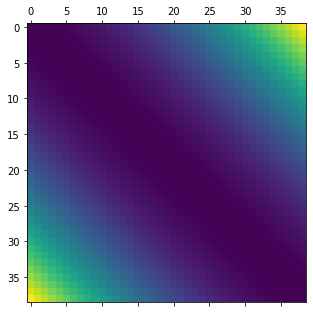

In [15]:
plt.matshow(M)

In [16]:
time_point = 550
Xt = X[:,time_point]
active_idxs = np.where(Xt>0)
ratemaps_t = firing_rate_maps[active_idxs]
distributions = ratemaps_t.T/np.sum(ratemaps_t,axis=-1)
weights = Xt[active_idxs]
weights = weights/sum(weights)

# wasserstein
reg = 1e-3
posterior = ot.bregman.barycenter(distributions, M, reg, weights)



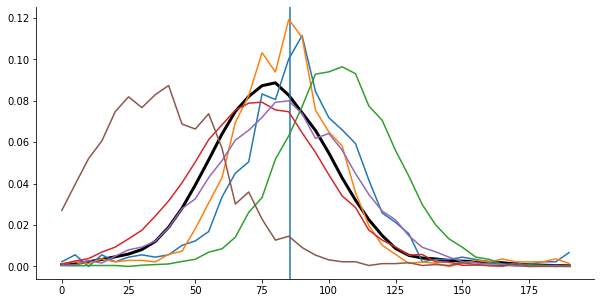

In [17]:
plt.plot(space_bins[:-1],posterior,c='k',linewidth=3)
plt.axvline(x=x[time_point])
for i in range(distributions.shape[-1]):
    plt.plot(space_bins[:-1],distributions[:,i])

sns.despine()

In [103]:
end_time = 10000
occupancy_dist = occupancy/sum(occupancy)
posteriors = []
decoded_x = []
for time_point in range(end_time):
    Xt = X[:,time_point]
    active_idxs = np.where(Xt>0)
    ratemaps_t = firing_rate_maps[active_idxs]
    distributions = ratemaps_t.T/np.sum(ratemaps_t,axis=-1)
    weights = Xt[active_idxs]
    weights = weights/sum(weights)

    # wasserstein
    reg = 1e-3
    neuron_posterior = ot.bregman.barycenter(distributions, M, reg, weights)
    posterior = neuron_posterior*occupancy_dist
    posteriors.append(posterior)
    decoded_x.append(space_bins[:-1][np.argmax(posterior)])



/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:1533: UserWarning

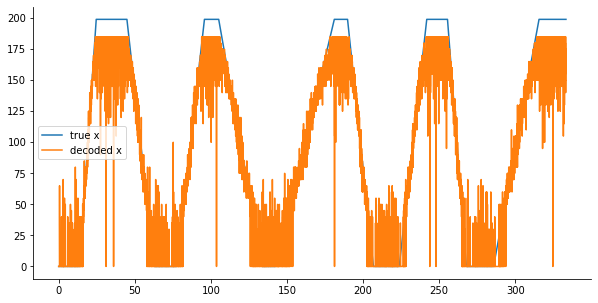

In [105]:
true_x = x[:end_time]
plt.plot(t[:end_time],true_x,label='true x')
plt.plot(t[:end_time],decoded_x,label='decoded x')
ot_errors = abs(x[:end_time]-decoded_x)
plt.legend()
sns.despine()

# NAIVE BAYES

In [94]:
def predict_posterior(X,ratemaps, occupancy,epsilon=pow(10, -15)):
        log_posteriors = X @ np.log(ratemaps+epsilon) - np.sum(ratemaps, axis=0) +np.log(occupancy)
        posteriors = np.exp(log_posteriors)
        return posteriors


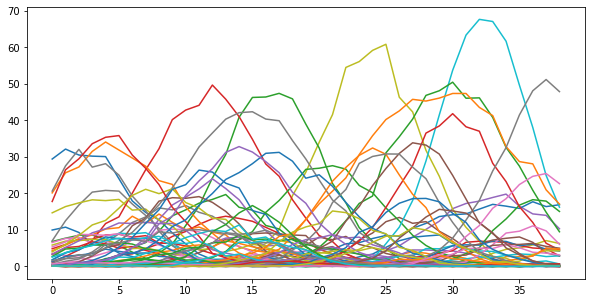

In [66]:
for i in firing_rate_maps:
    plt.plot(i)

In [95]:
distributions = firing_rate_maps.T/np.sum(firing_rate_maps,axis=-1)
occupancy_dist = occupancy/sum(occupancy)
NB_posteriors = predict_posterior(X[:,:end_time].T,distributions.T,occupancy_dist)
NB_pred_x = [space_bins[:-1][np.argmax(NB_posterior)] for NB_posterior in NB_posteriors]

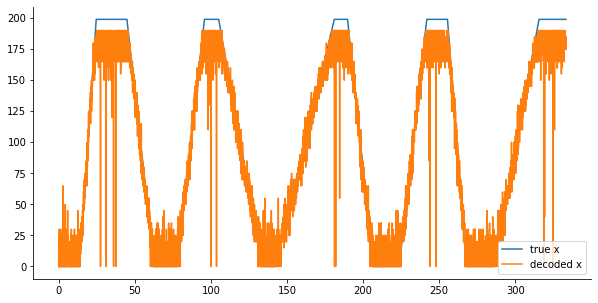

In [96]:
true_x = x[:end_time]
plt.plot(t[:end_time],true_x,label='true x')
plt.plot(t[:end_time],NB_pred_x,label='decoded x')
nb_errors = abs(x[:end_time]-NB_pred_x)
plt.legend()
sns.despine()

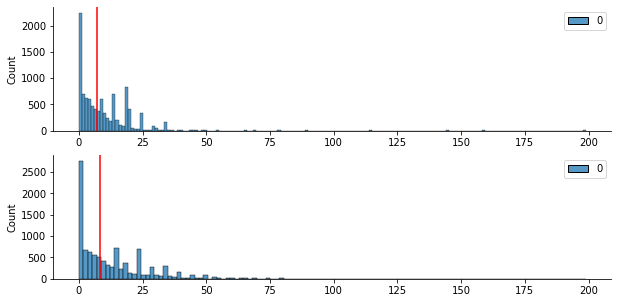

In [106]:
plt.subplot(2,1,1)
sns.histplot(data=[nb_errors])
plt.axvline(x=np.median(nb_errors),c='r')

plt.subplot(2,1,2)
sns.histplot(data=[ot_errors])
plt.axvline(x=np.median(ot_errors),c='r')

sns.despine()


In [107]:
# only during speed >0
speed = np.diff(x[:end_time])
speed_idxs = np.where(abs(speed)>0)

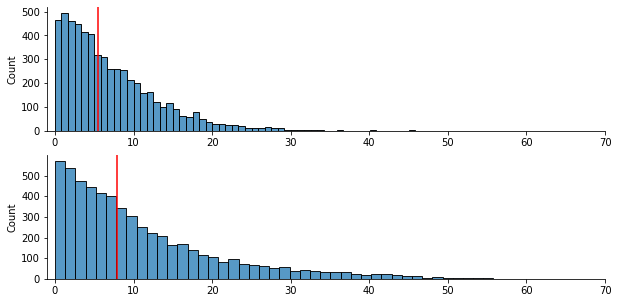

In [108]:
plt.subplot(2,1,1)
filtered_nb_err = nb_errors[:-1][speed_idxs]
sns.histplot(data=filtered_nb_err)
plt.axvline(x=np.median(filtered_nb_err),c='r')
plt.xlim([-1,70])
plt.subplot(2,1,2)
filtered_ot_err = ot_errors[:-1][speed_idxs]
sns.histplot(data=filtered_ot_err)
plt.axvline(x=np.median(filtered_ot_err),c='r')
plt.xlim([-1,70])

sns.despine()

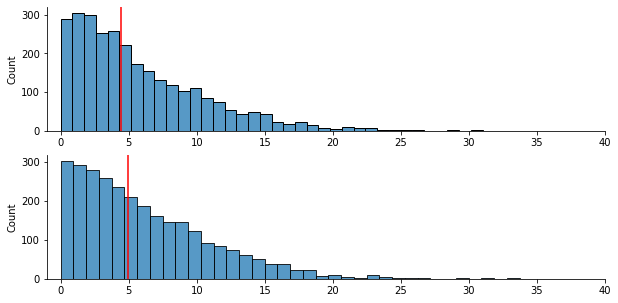

In [109]:
pos_idxs = np.where(np.logical_and(x[:end_time]>50,x[:end_time]<150))
plt.subplot(2,1,1)
filtered_nb_err = nb_errors[pos_idxs]
sns.histplot(data=filtered_nb_err)
plt.axvline(x=np.median(filtered_nb_err),c='r')
plt.xlim([-1,40])
plt.subplot(2,1,2)
filtered_ot_err = ot_errors[pos_idxs]
sns.histplot(data=filtered_ot_err)
plt.axvline(x=np.median(filtered_ot_err),c='r')
plt.xlim([-1,40])

sns.despine()